# Notebook for non-kernal models

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from scripts.nested_CV import nested_cv

In [26]:
# configs
seed = 42  # for repeatability

### Data import and preprocessing

In [27]:
# data
file_path = "../data/laser.mat"
mat = loadmat(file_path)

X = mat["X"]
y = mat["Y"].reshape(200)

print(X.shape, y.shape)

(200, 60) (200,)


In [28]:
# normalizing the data and splitting into train/test splits
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

## Baseline 1: Linear Classification - No regularization (Ordinary Least squares)

In [29]:
clf_ols = LinearRegression()
clf_ols.fit(X_train, y_train)
y_pred = clf_ols.predict(X_test)
y_class = np.where(y_pred >= 0, 1, -1)
print(classification_report(y_test, y_class))

              precision    recall  f1-score   support

          -1       0.80      0.94      0.86        17
           1       0.95      0.83      0.88        23

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.89      0.88      0.88        40



## Basline 2: Logistic Regression

In [30]:
clf_log = LogisticRegression(max_iter=1000)
clf_log.fit(X_train, y_train)
y_pred_log = clf_log.predict(X_test)
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

          -1       0.83      0.88      0.86        17
           1       0.91      0.87      0.89        23

    accuracy                           0.88        40
   macro avg       0.87      0.88      0.87        40
weighted avg       0.88      0.88      0.88        40



## BUT ..... 

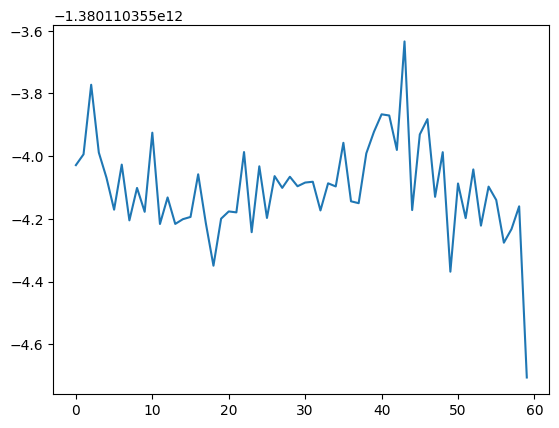

In [31]:
plt.plot(clf_ols.coef_)

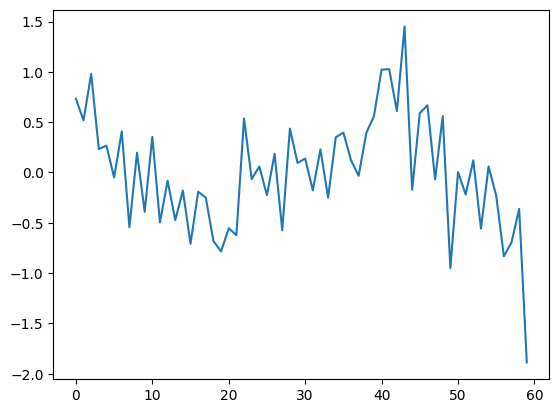

In [32]:
plt.plot(clf_log.coef_[0])